# Análise inicial dos dados do Mosaico

**Higo Thaian Pereira da Silva** [(higo.silva@redes.unb.br)](mailto:higo.silva@redes.unb.br)

Neste _notebook_ é apresentado uma análise inicial do dados dispostos na plataforma [Mosaico](http://sistemas.anatel.gov.br/se/public/view/b/srd.php). O objetivo da análise é encontrar erros de preenchimento nas tabelas dispostas na plataforma. Os erros podem ser **campos não preenchidos** ou **campos preenchidos incorretamente**. Os dados extraídos da plataforma estão dispostos no arquivo `./data/canais_mosaico.csv`.

## 1.1 Leitura dos dados

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle

# Import data
pd.set_option('display.max_columns', None) 
data_frame = pd.read_csv("./data/canais_mosaico.csv", sep = ';', dtype={'dec':'str', 'hci':'str', 'id':'str'})
data_frame.head()

,status,cnpj,entity,num_fistel,carater,finalidade,service,num_service,UF,city,local_especifico,canal,dec,frequency,class,category,latitude,longitude,erp,hci,gen_fistel,fase,data,id,channel_id
0,TV-C1 (Canal Outorgado - Aguardando Ato de RF),1.865469e+12,REDE DE COMUNICACOES ACREANA LTDA,5.044289e+10,P,Comercial,TV,248,AC,Cruzeiro do Sul,NaN,12.0,NaN,207.0,A,NaN,"7° 37 52.00"""""""" S""""","72° 40 12.00"""""""" W""""",31.600,NaN,NaN,1.0,2022-08-05 15:06:51,NaN,57dbaad04f6cc
1,TV-C1 (Canal Outorgado - Aguardando Ato de RF),3.211814e+12,X-MEDIAGROUP S.A.,5.041089e+10,P,Comercial,TV,248,AC,Mâncio Lima,NaN,25.0,NaN,539.0,C,NaN,"7° 36 51.00"""""""" S""""","72° 53 45.00"""""""" W""""",1.600,NaN,NaN,1.0,2021-03-16 15:36:26,NaN,57dbaad053c60
2,TV-C0 (Canal Vago),NaN,NaN,NaN,P,Comercial,TV,248,AC,Rio Branco,NaN,29.0,NaN,563.0,A,NaN,"9° 58 0.00"""""""" S""""","67° 49 0.00"""""""" W""""",160.000,NaN,NaN,0.0,2021-11-12 15:33:57,NaN,57dbaad06f48a
3,TV-C0 (Canal Vago),NaN,NaN,NaN,P,Comercial,TV,248,AC,Rio Branco,NaN,56.0,NaN,725.0,A,NaN,"9° 58 29.00"""""""" S""""","67° 48 36.00"""""""" W""""",160.000,NaN,NaN,0.0,2021-11-12 15:33:57,NaN,57dbaad070cdc
4,TV-C0 (Canal Vago),NaN,NaN,NaN,P,Comercial,TV,248,AL,Arapiraca,NaN,50.0,NaN,689.0,C,NaN,"9° 45 9.00"""""""" S""""","36° 39 40.00"""""""" W""""",1.377,NaN,NaN,0.0,2021-03-16 15:36:26,NaN,57dbaad07252c


## 1.2 Análise da coluna `cnpj`

O CNPJ é composto por 14 dígitos, no formato XX.XXX.XXX/YYYY-ZZ, em que os oito primeiros números são a raiz de identificação da empresa, os quatro dígitos após a barra representam a unidade de atuação e os dois últimos representam o dígito verificador. Na tabela de dados, o CNPJ não contém os símbolos separadores (. e /). Uma sequência de dígitos com comprimento diferente de 14 no campo **CNPJ** configura um erro de preenchimento.

A seguir, os dados de CNPJ são analisados e são calculados os números de campos vazios e de campos preenchidos com valores de formato adequado. É importante ressaltar que a correta formatação dos CNPJs não implica em sua existência.

De um total de 41807 CNPJs, constam 10754 CNPJs não preenchidos (25.72%) e 17264 com 14 dígitos (41.29%). Dos 17264 CNPJs com 14 dígitos, 17264 têm formato adequado (100.00%).


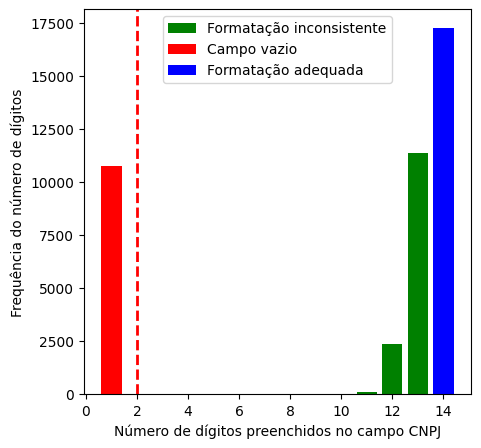

In [174]:
LENGTH_CNPJ = 14

# Função para validar o formato do CNPJ
def is_cnpj_valido(cnpj: str) -> int:
    if len(cnpj) != LENGTH_CNPJ:
        return 0

    cnpj_r = cnpj[::-1]
    for i in range(2, 0, -1):
        cnpj_enum = zip(cycle(range(2, 10)), cnpj_r[i:])
        dv = sum(map(lambda x: int(x[1]) * x[0], cnpj_enum)) * 10 % 11
        if cnpj_r[i - 1:i] != str(dv % 10):
            return 1

    return True


# Fill empty values with '0' and convert column to int
data_frame['cnpj'].fillna(0, inplace=True)
data_frame = data_frame.astype({'cnpj':'int'})

# Compute the total number of fields
num_total_cnpjs = len(data_frame['cnpj'])
# Compute the number of empty CNPJs
num_empty_cnpjs = data_frame['cnpj'].value_counts()[0]
# Compute the number of CNPJs with 14 digits
num_formated_cnpjs = data_frame['cnpj'].astype(str).str.len().value_counts()[LENGTH_CNPJ]
# Calculates the number of CNPJs with proper format
num_valid_cnpjs = data_frame['cnpj'].astype(str).apply(is_cnpj_valido).sum()
# Empty percentual
empty_percentual = num_empty_cnpjs/num_total_cnpjs

print(f"De um total de {num_total_cnpjs} CNPJs," \
      f" constam {num_empty_cnpjs} CNPJs não preenchidos ({empty_percentual * 100:.2f}%) e " \
      f"{num_formated_cnpjs} com 14 dígitos ({num_formated_cnpjs/num_total_cnpjs * 100:.2f}%)." \
      f" Dos {num_formated_cnpjs} CNPJs com 14 dígitos, {num_valid_cnpjs} têm formato adequado " \
      f"({num_valid_cnpjs/num_formated_cnpjs * 100:.2f}%).")

# Calculate the number of digits of cnpjs
cnpj_num_digits = data_frame['cnpj'].astype(str).str.len().value_counts().tolist()
cnpj_num_digits_index = data_frame['cnpj'].astype(str).str.len().value_counts().keys().tolist()

fig = plt.figure(figsize=(5,5))
plt.bar( cnpj_num_digits_index, cnpj_num_digits, color='g', label='Formatação inconsistente' )
plt.bar( cnpj_num_digits_index[cnpj_num_digits_index.index(1)], cnpj_num_digits[cnpj_num_digits_index.index(1)], color='r', label='Campo vazio' )
plt.bar( cnpj_num_digits_index[cnpj_num_digits_index.index(LENGTH_CNPJ)], cnpj_num_digits[cnpj_num_digits_index.index(LENGTH_CNPJ)], color='b', label='Formatação adequada' )

plt.axvline(x=2, color='r', ls='--', lw=2)
plt.xlabel('Número de dígitos preenchidos no campo CNPJ')
plt.ylabel('Frequência do número de dígitos')
plt.legend(loc="upper center")

## 1.3 Análise da coluna `num_fistel`

O **número do Fistel** é um código numérico **composto de onze dígitos** que identifica a autorização que o usuário possui para determinado serviço. Assim, cada outorga, equivalerá a um número de Fistel [[Fonte]](https://www.sertsc.org.br/site/taxas-fistel-que-vencerao-em-31-de-marco-ja-estao-disponiveis-no-site-da-anatel/).

Devido a falta de informações acerca da formatação do número do Fistel, a checagem de erros deste campo se baseia apenas na contagem de campos vazios e de campos com um número de dígitos inadequado.




De um total de 41807 números de Fistel, constam 10756 não preenchidos (25.72%) e 28130 com 11 dígitos (67.29%).Ou seja, no mínimo 13677 valores (32.71%) foram preenchidos de forma errada.


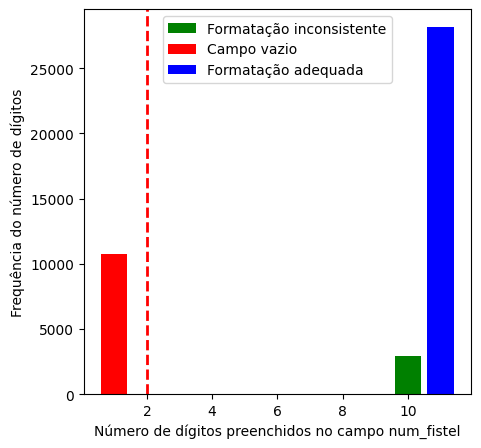

In [188]:
LENGTH_FISTEL = 11


# Fill empty values with '0' and convert column to int
data_frame['num_fistel'].fillna(0, inplace=True)
data_frame = data_frame.astype({'num_fistel':'int'})

# Compute the total number of fields
num_total_fistels = len(data_frame['num_fistel'])
# Compute the number of empty Fistel's numbers
num_empty_fistels = data_frame['num_fistel'].value_counts()[0]
# Compute the number of Fistels with 11 digits
num_formated_fistels = data_frame['num_fistel'].astype(str).str.len().value_counts()[LENGTH_FISTEL]
# Empty percentual
empty_percentual = num_empty_cnpjs/num_total_cnpjs
error_percentual = (num_total_cnpjs - num_formated_fistels) / num_total_cnpjs

print(f"De um total de {num_total_fistels} números de Fistel," \
      f" constam {num_empty_fistels} não preenchidos ({empty_percentual * 100:.2f}%) e " \
      f"{num_formated_fistels} com 11 dígitos ({num_formated_fistels/num_total_fistels * 100:.2f}%)." \
      f"Ou seja, no mínimo {num_total_fistels - num_formated_fistels} valores ({error_percentual * 100:.2f}%) foram preenchidos de forma errada." )

# Calculate the number of digits of cnpjs
fistel_num_digits = data_frame['num_fistel'].astype(str).str.len().value_counts().tolist()
fistel_num_digits_index = data_frame['num_fistel'].astype(str).str.len().value_counts().keys().tolist()

fig = plt.figure(figsize=(5,5))
plt.bar( fistel_num_digits_index, fistel_num_digits, color='g', label='Formatação inconsistente' )
plt.bar( fistel_num_digits_index[fistel_num_digits_index.index(1)], fistel_num_digits[fistel_num_digits_index.index(1)], color='r', label='Campo vazio' )
plt.bar( fistel_num_digits_index[fistel_num_digits_index.index(LENGTH_FISTEL)], fistel_num_digits[fistel_num_digits_index.index(LENGTH_FISTEL)], color='b', label='Formatação adequada' )

plt.axvline(x=2, color='r', ls='--', lw=2)
plt.xlabel('Número de dígitos preenchidos no campo num_fistel')
plt.ylabel('Frequência do número de dígitos')
plt.legend(loc="upper center")



## 1.3 Análise da coluna `carater`


In [209]:
data_frame['carater'].value_counts()

P    32682
S     9125
Name: carater, dtype: int64

O campo `carater` está completamente preenchido com caracteres `P` ou `S`.

Text(0.5, 1.0, 'Frequência de ocorrência dos valores no campo carater')

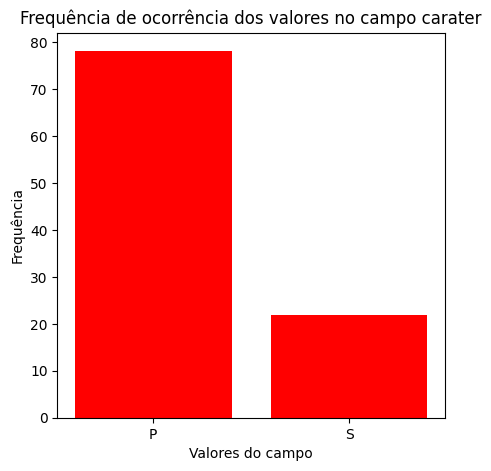

In [211]:
data_frame['carater'].value_counts()
carater_count = data_frame['carater'].value_counts()

fig = plt.figure(figsize=(5,5))
plt.bar( carater_count.index, ( carater_count.values / carater_count.values.sum() ) * 100, color='r', label='Formatação inconsistente' )
plt.xlabel('Valores do campo')
plt.ylabel('Frequência')
plt.title('Frequência de ocorrência dos valores no campo carater')

## 1.4 Análise da coluna `finalidade`

In [212]:
data_frame['finalidade'].value_counts()

Comercial             30199
0° 00 0.00"""" N""     5938
Publica                3742
Educativo              1920
Educativo publico         6
0° 00 0.00"" N""          2
Name: finalidade, dtype: int64

Percebe-se que nesse campo há quatro prováveis **finalidades**:
- Comercial;
- Pública (`Publica`);
- Educativo;
- Educativo público (`Educativo publico`).

Entretanto, percebe-se que existe uma alta ocorrência (5938) de um preenchimento com uma `string` de coordenada (`0° 00 0.00"""" N""`).